In [2]:
import math
import operator
from pathlib import Path

from ipywidgets import fixed, interact
import ipywidgets as widgets
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import describe, gaussian_kde
import seaborn as sns

from DET import DET

mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

# Biometric performance evaluation
In a biometric system performance evaluation, we distinguish between two types of scores:

* Mated (also called genuine) - i.e. comparisons between different samples (images) from the same data subject (person)
* Non-mated (also called impostor) - i.e. comparisons between samples (images) from different data subjects (persons)

Subsequently, it is evaluated whether correct decisions (accepting mated attempts and rejecting non-mated attempts) can be made based on the scores and a static decision threshold. Let's consider an example.

## Load scores
In this example, scores are conveniently stored in text files and divided into mated and non-mated ones. You may have to do some pre-processing of your own data in order to have the scores neatly stored.

In [3]:
system_name1 = "original pictures"
mated_score_file1 = 'C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_original.txt'
nonmated_score_file1 = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/non_mated_correlations.txt"
mated_scores1 = np.loadtxt(mated_score_file1)
nonmated_scores1 = np.loadtxt(nonmated_score_file1)
scores_type1 = "similarity"

## Explore scores
Let's explore the scores with some basic descriptive statistical methods.

In [4]:
def descriptive_statistics(mated_scores, nonmated_scores):
    stats_labels = ["Observations", "Minimum", "Maximum", "Mean", "St. Dev.", "Skewness", "Ex. Kurtosis"]
    mated_stats = describe(mated_scores)
    mated_stats = [mated_stats.nobs, mated_stats.minmax[0], mated_stats.minmax[1], mated_stats.mean, math.sqrt(mated_stats.variance), mated_stats.skewness, mated_stats.kurtosis]
    nonmated_stats = describe(nonmated_scores)
    nonmated_stats = [nonmated_stats.nobs, nonmated_stats.minmax[0], nonmated_stats.minmax[1], nonmated_stats.mean, math.sqrt(nonmated_stats.variance), nonmated_stats.skewness, nonmated_stats.kurtosis]

    stats_system_df = pd.DataFrame(np.array([stats_labels, mated_stats, nonmated_stats]).T, columns=["Statistic", "Mated", "Non-mated"])
    stats_system_df = stats_system_df.astype({"Statistic": str, "Mated": float, "Non-mated": float})
    return stats_system_df

stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
rounded_df = stats_system1_df.round(round_digits)  # Round the values
result_string = rounded_df.to_string(index=False)  # Get string without index
print(result_string)

   Statistic      Mated   Non-mated
Observations 9500.00000 19900.00000
     Minimum   -0.12749    -0.21133
     Maximum    0.98446     0.50220
        Mean    0.50323     0.09731
    St. Dev.    0.15585     0.08911
    Skewness   -0.42125     0.31458
Ex. Kurtosis    0.03081     0.37775


We can observe several things. There are many more non-mated scores than mated scores -- this is typical, since there simply are many more possibilities of comparing samples from two different subjects than from the same subjects. Also, the mated scores tend to be closer to 1 (perfect similarity) than the non-mated scores. That is good -- perhaps there is a clear separation between the two? Fortunately, we can investigate that as well.

## Plot histograms
Using histograms, the distributions of the two score types can be visualised.

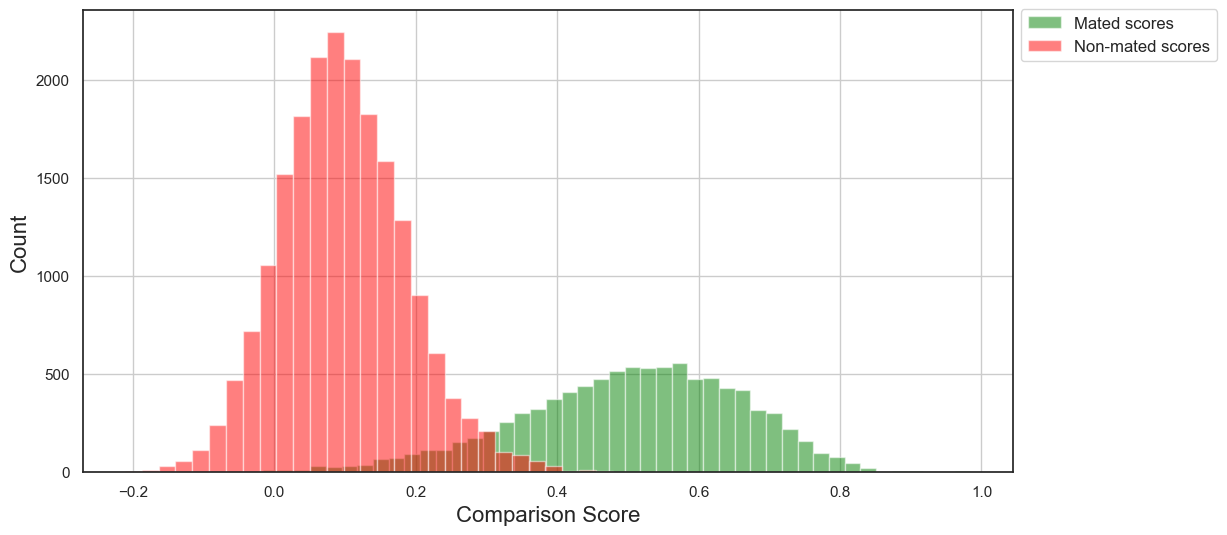

In [5]:
def plot_histogram(mated_scores, nonmated_scores, normalise=True, savename=None):
    def normalise_scores(distribution):
        return np.ones_like(distribution) / len(distribution)
    plt.figure(figsize=figure_size)
    if normalise:
        plt.hist(mated_scores, bins=50, weights=normalise_scores(mated_scores), color=mated_colour, alpha=0.5, label=mated_label)
        plt.hist(nonmated_scores, bins=30, weights=normalise_scores(nonmated_scores), color=nonmated_colour, alpha=0.5, label=nonmated_label)
        xlabel = "Probability Density"
    else:
        plt.hist(mated_scores, bins=50, color=mated_colour, alpha=0.5, label=mated_label)
        plt.hist(nonmated_scores, bins=30, color=nonmated_colour, alpha=0.5, label=nonmated_label)
        xlabel = "Count"
    plt.xlabel("Comparison Score", size=label_fontsize)
    plt.ylabel(xlabel, size=label_fontsize)
    plt.grid(True)
    plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)
    
    if savename is not None:
        plt.savefig(savename, bbox_inches="tight")
        plt.cla()
        plt.clf()
        plt.close()
    else:
        plt.show()
    
plot_histogram(mated_scores1, nonmated_scores1, normalise=False)

Typically, we have more (sometimes orders of magnitude) non-mated comparison scores available -- we need to normalise!

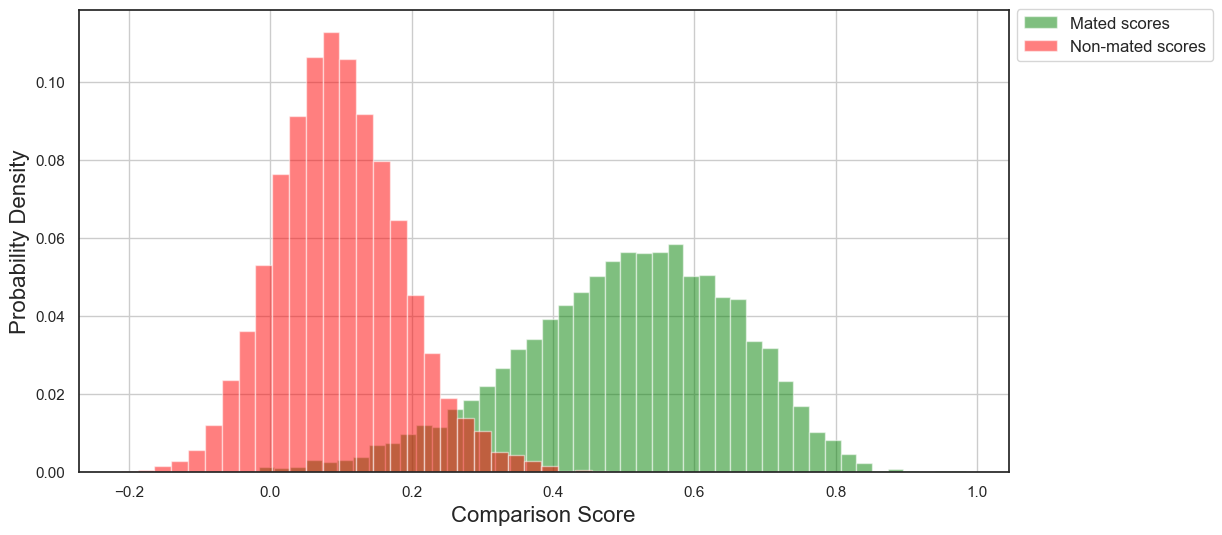

In [6]:
plot_histogram(mated_scores1, nonmated_scores1, normalise=True)

This now looks much better. We can also use a built-in KDE function.

In [7]:
def get_kde(distribution, linspace_items=101):
    dist_min, dist_max = distribution.min(), distribution.max()
    dist_kde = gaussian_kde(distribution)
    dist_pos = np.linspace(dist_min, dist_max, linspace_items)
    return dist_kde, dist_pos, dist_min, dist_max

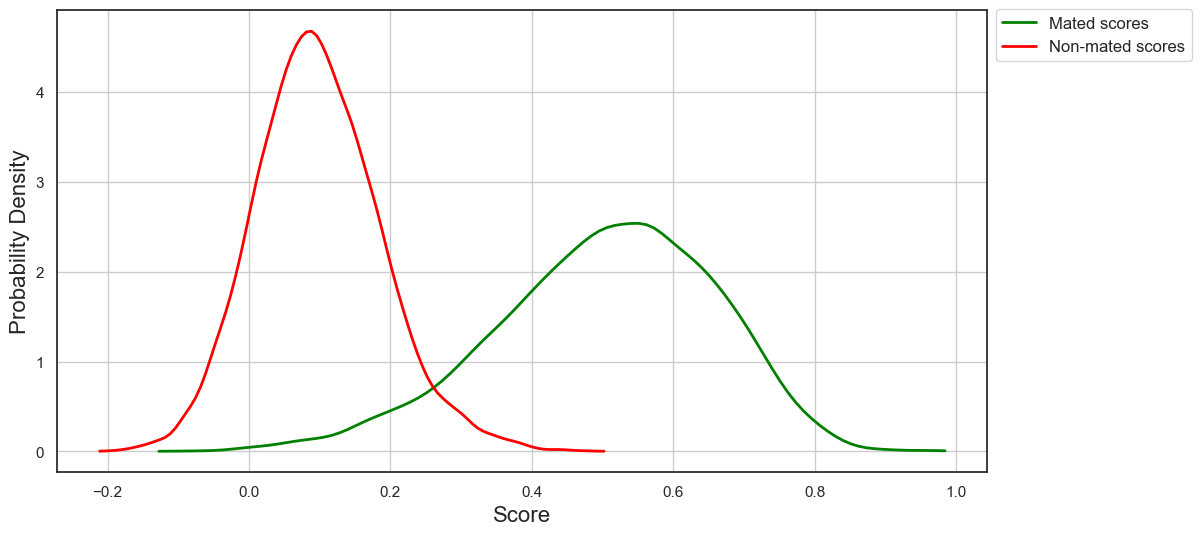

In [8]:
mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores1)
nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores1)
plt.figure(figsize=figure_size)
plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
plt.xlabel("Score", size=label_fontsize)
plt.ylabel("Probability Density", size=label_fontsize)
plt.grid(True)
plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)
plt.show()

## Separability and Thresholding
There seems to be a decent separation (i.e. not much overlap) between the two score distributions above. We can quantify this using the so-called [sensitivity index](https://en.wikipedia.org/wiki/Sensitivity_index), which is a dimensionless metric which measures the separation between two distributions. Although it assumes the data is normally distributed (which is not always the case with biometric data) and does not take into account higher order moments (e.g. skewness and kurtosis), it can still give a reasonable approximate of how well the mated and non-mated scores are separated (larger value means better separation). It is computed as follows: $$d' = \frac{\|\mu_{mated} - \mu_{non-mated}\|}{\sqrt{\frac{1}{2}\left(\sigma_{mated}^2 + \sigma_{non-mated}^2\right)}}$$

In [9]:
def d_prime(distribution1, distribution2):
    mean1, mean2 = np.mean(distribution1), np.mean(distribution2)
    std1, std2 = np.std(distribution1), np.std(distribution2)
    return abs(mean1 - mean2) / math.sqrt(0.5 * (std1 ** 2 + std2 ** 2))

In [10]:
d_prime_system1 = d_prime(mated_scores1, nonmated_scores1)
print("d' =", round(d_prime_system1, round_digits))

d' = 3.1977


Since the distributions are quite well separated, it means, that if we were to set a static score threshold, it would be possible to classify a (new) score as either "mated" if it is above the threshold, or "non-mated" if it is below. Let's visualise this.

In [11]:
def kde_with_threshold(mated_scores, nonmated_scores, scores_type, threshold, savename=None): 
    linspace_items = 101
    mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores, linspace_items)
    nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores, linspace_items)
    
    plt.figure(figsize=figure_size)
    plt.xlabel("Comparison Score", size=label_fontsize)
    plt.ylabel("Probability Density", size=label_fontsize)
    
    def compute_fills(scores_type, mated_min, mated_max, nonmated_min, nonmated_max, linspace_items):
        if scores_type == "similarity":
            if mated_min < threshold:
                mated_shade = np.linspace(threshold, mated_max, linspace_items)
                mated_fill = np.linspace(mated_min, threshold, linspace_items) 
            else:
                mated_shade = np.linspace(mated_min, mated_max, linspace_items)
                mated_fill = None
            if nonmated_max > threshold:
                nonmated_shade = np.linspace(nonmated_min, threshold, linspace_items)
                nonmated_fill = np.linspace(threshold, nonmated_max, linspace_items)
            else:
                nonmated_shade = np.linspace(nonmated_min, nonmated_max, linspace_items)
                nonmated_fill = None
        elif scores_type == "dissimilarity":
            if mated_max > threshold:
                mated_shade = np.linspace(mated_min, threshold, linspace_items)
                mated_fill = np.linspace(threshold, mated_max, linspace_items) 
            else:
                mated_shade = np.linspace(mated_min, mated_max, linspace_items)
                mated_fill = None
            if nonmated_min < threshold:
                nonmated_shade = np.linspace(threshold, nonmated_max, linspace_items)
                nonmated_fill = np.linspace(nonmated_min, threshold, linspace_items)
            else:
                nonmated_shade = np.linspace(nonmated_min, nonmated_max, linspace_items)
                nonmated_fill = None
        else:
            raise ValueError(f"Unknown type of comparison scores: {scores_type}")
        return mated_shade, mated_fill, nonmated_shade, nonmated_fill
    
    plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
    plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
     
    mated_shade, mated_fill, nonmated_shade, nonmated_fill = compute_fills(scores_type, mated_min, mated_max, nonmated_min, nonmated_max, linspace_items)
    
    plt.fill_between(mated_shade, mated_kde(mated_shade), alpha=alpha_shade, color=mated_colour) 
    plt.fill_between(nonmated_shade, nonmated_kde(nonmated_shade), alpha=alpha_shade, color=nonmated_colour) 
    
    if mated_fill is not None:
        plt.fill_between(mated_fill, mated_kde(mated_fill), alpha=alpha_fill, color=mated_colour)
    if nonmated_fill is not None:
        plt.fill_between(nonmated_fill, nonmated_kde(nonmated_fill), alpha=alpha_fill, color=nonmated_colour)

    plt.axvline(threshold, linewidth=linewidth, linestyle=threshold_style, color=threshold_colour, label="Decision threshold = 0.2398")
    
    plt.legend(loc="upper right")
    red_patch = mpatches.Patch(color=nonmated_colour, alpha=alpha_fill, label='False positives')
    green_patch = mpatches.Patch(color=mated_colour, alpha=alpha_fill, label='False negatives')
    shaded_red_patch = mpatches.Patch(color=nonmated_colour, alpha=alpha_shade, label='True negatives')
    shaded_green_patch = mpatches.Patch(color=mated_colour, alpha=alpha_shade, label='True positives')
    current_handles, _ = plt.gca().get_legend_handles_labels()
    
    plt.grid(True)
    plt.legend(loc="upper right", bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize, handles=[green_patch, red_patch, shaded_green_patch, shaded_red_patch]+current_handles)
    plt.xlim(0, 1)
    plt.ylim(0, None)
    
    if savename is not None:
        plt.savefig(savename, bbox_inches="tight")
        plt.cla()
        plt.clf()
        plt.close()
    else:
        plt.show()

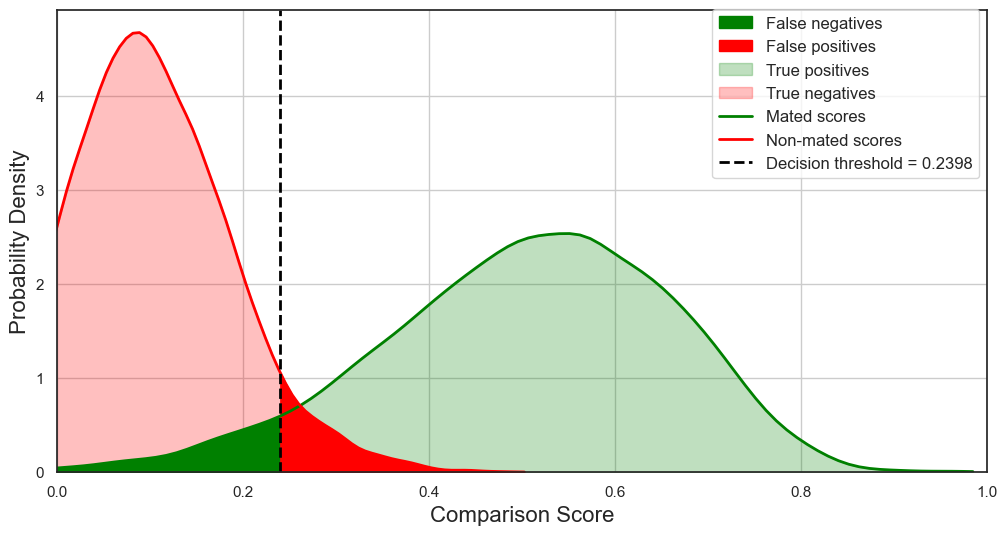

In [12]:
threshold1 = 0.23982732133720322
kde_with_threshold(mated_scores1, nonmated_scores1, scores_type1, threshold1)

What happened? We set the decision threshold to 0.5. Every score above this threshold is classified as "mated", whereas every score below that threshold is classified as "non-mated". In the plot, we can see that most items would have been classified correctly (mated as mated, i.e. accepted, and non-mated as non-mated, i.e. rejected) -- those are the parts of distribution with bleak colour (low alpha value). However, some classification errors (mated as non-mated, i.e. rejected, and non-mated as mated, i.e. accepted) would have occurred -- those are the highlighted parts of the distributions (high alpha value). Let's quantify those errors in a confusion matrix.

## Confusion matrix
[This commonly used method](https://en.wikipedia.org/wiki/Confusion_matrix) allows us to concisely visualise the performance (accuracy) of our decision making algorithm at a given threshold.

In [13]:
def get_confusion_matrix(mated_scores, nonmated_scores, scores_type, threshold, mode="percent"):
    if scores_type == "similarity":
        true_accepts_count = [score >= threshold for score in mated_scores].count(True)
        true_rejects_count = [score < threshold for score in nonmated_scores].count(True)
        false_accepts_count = [score >= threshold for score in nonmated_scores].count(True)
        false_rejects_count = [score < threshold for score in mated_scores].count(True)
    elif scores_type == "dissimilarity":
        true_accepts_count = [score <= threshold for score in mated_scores].count(True)
        true_rejects_count = [score > threshold for score in nonmated_scores].count(True)
        false_accepts_count = [score <= threshold for score in nonmated_scores].count(True)
        false_rejects_count = [score > threshold for score in mated_scores].count(True)
    else:
        raise ValueError(f"Unknown type of comparison scores: {scores_type}")
    if mode == "count":
        confusion_matrix_system_df = pd.DataFrame(np.array([["Mated", "Non-mated"], [true_accepts_count, false_rejects_count], [false_accepts_count, true_rejects_count]]).T, columns=["Predicted/Actual", "Mated", "Non-mated"])
    elif mode == "percent":
        mated_count = len(mated_scores)
        nonmated_count = len(nonmated_scores)
        true_accepts_percent = true_accepts_count / mated_count * 100
        true_rejects_percent = true_rejects_count / nonmated_count * 100
        false_accepts_percent = false_accepts_count / nonmated_count * 100
        false_rejects_percent = false_rejects_count / mated_count * 100
        confusion_matrix_system_df = pd.DataFrame(np.array([["Mated", "Non-mated"], [true_accepts_percent, false_rejects_percent], [false_accepts_percent, true_rejects_percent]]).T, columns=["Predicted/Actual", "Mated", "Non-mated"])
    else:
        raise ValueError("Wrong mode: {}".format(mode))
    return confusion_matrix_system_df.astype({"Predicted/Actual": str, "Mated": float if mode == "percent" else int, "Non-mated": float if mode == "percent" else int}), true_accepts_count, true_rejects_count, false_accepts_count, false_rejects_count

def style_confusion_matrix(confusion_matrix):
  hex_color_green_fill = "#008000"
  hex_color_red_shade = "#ffbfbf"
  hex_color_green_shade = "#bfdfbf"
  hex_color_red_fill = "#ff0000"
  styled_df = confusion_matrix.style.applymap(lambda x: f'background-color: {hex_color_green_shade}', subset=pd.IndexSlice[[0], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_fill}', subset=pd.IndexSlice[[0], ['Non-mated']]).applymap(lambda x: f'background-color: {hex_color_green_fill}', subset=pd.IndexSlice[[1], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_shade}', subset=pd.IndexSlice[[1], ['Non-mated']])
  return styled_df.to_string()  # Get string representation without index

confusion_matrix_df, true_accepts_count, true_rejects_count, false_accepts_count, false_rejects_count = get_confusion_matrix(mated_scores1, nonmated_scores1, scores_type1, threshold1, mode="count")
FNMR = false_rejects_count / (false_rejects_count + true_accepts_count)
FMR = false_accepts_count / (false_accepts_count + true_rejects_count)

accuracy = ((true_accepts_count + true_rejects_count) / (true_accepts_count+true_rejects_count+false_accepts_count+false_rejects_count)) * 100

print("true accepts count (TP) =", true_accepts_count)
print("true rejects count (TN)=", true_rejects_count)
print("false accepts count (FP) =", false_accepts_count)
print("false rejects count (FN) =", false_rejects_count)
print("FMR =", FMR*100)
print("FNMR =", FNMR*100)
print("Accuracy =", accuracy)
print("------------------------------------")

print(style_confusion_matrix(confusion_matrix_df))

true accepts count (TP) = 8933
true rejects count (TN)= 18714
false accepts count (FP) = 1186
false rejects count (FN) = 567
FMR = 5.959798994974874
FNMR = 5.968421052631579
Accuracy = 94.0374149659864
------------------------------------
 Predicted/Actual Mated Non-mated
0 Mated 8933 1186
1 Non-mated 567 18714



C:\Users\Admin\AppData\Local\Temp\ipykernel_15660\1095247730.py:33: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = confusion_matrix.style.applymap(lambda x: f'background-color: {hex_color_green_shade}', subset=pd.IndexSlice[[0], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_fill}', subset=pd.IndexSlice[[0], ['Non-mated']]).applymap(lambda x: f'background-color: {hex_color_green_fill}', subset=pd.IndexSlice[[1], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_shade}', subset=pd.IndexSlice[[1], ['Non-mated']])


We can also compute the matrix as percentages:

In [14]:
confusion_matrix_df, _, _, _, _ = get_confusion_matrix(mated_scores1, nonmated_scores1, scores_type1, threshold1, mode="percent")
print(style_confusion_matrix(confusion_matrix_df))


 Predicted/Actual Mated Non-mated
0 Mated 94.031579 5.959799
1 Non-mated 5.968421 94.040201



C:\Users\Admin\AppData\Local\Temp\ipykernel_15660\1095247730.py:33: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = confusion_matrix.style.applymap(lambda x: f'background-color: {hex_color_green_shade}', subset=pd.IndexSlice[[0], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_fill}', subset=pd.IndexSlice[[0], ['Non-mated']]).applymap(lambda x: f'background-color: {hex_color_green_fill}', subset=pd.IndexSlice[[1], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_shade}', subset=pd.IndexSlice[[1], ['Non-mated']])


In other words, we correctly classify approximately 95% of mated attempts as mated (true accept), and approximately 95% of non-mated attempts as non-mateds (true rejects). However, some errors are present -- approximately 5% non-mated attempts are incorrectly classified as mated (false accepts, type I error), and approximately 5% of mated attempts as non-mateds (false rejects, type II error). **By computing the accuracy at the given threshold, we found one operating point of the algorithm we are evaluating. But, what about other thresholds?** We could have tested arbitrarily many thresholds in the range of the score distributions to visualise the entire spectrum of possible operating points. Let's try this.

### Find the EER (equal error rate), the threshold for which FMR = FNMR (FP/(FP+TN) = FN/(FN+TP))

In [15]:
import numpy as np
import math

def find_equal_error_rate_threshold(mated_scores, nonmated_scores, scores_type, initial_range, tolerance=1e-5, max_iterations=1000):
    lower, upper = initial_range
    iteration = 0

    while iteration < max_iterations:
        iteration += 1
        threshold_range = np.linspace(lower, upper, num=200)
        for threshold in threshold_range:
            confusion_matrix_df, true_accepts_count, true_rejects_count, false_accepts_count, false_rejects_count = get_confusion_matrix(mated_scores, nonmated_scores, scores_type, threshold, mode="count")
            FMR = false_accepts_count / (false_accepts_count + true_rejects_count)
            FNMR = false_rejects_count / (false_rejects_count + true_accepts_count)

            # Check if FMR and FNMR are equal up to the specified decimal place
            if math.isclose(FMR, FNMR, rel_tol=tolerance):
                print(f"Threshold for FMR=FNMR: {threshold}")
                print("True Accepts (TP):", true_accepts_count)
                print("True Rejects (TN):", true_rejects_count)
                print("False Accepts (FP):", false_accepts_count)
                print("False Rejects (FN):", false_rejects_count)
                print(f"FMR: {FMR*100:.2f}%")
                print(f"FNMR: {FNMR*100:.2f}%")
                print(style_confusion_matrix(confusion_matrix_df))
                return threshold

            # Adjust the range based on the comparison
            if FMR > FNMR:
                upper = threshold
            else:
                lower = threshold

        # If no exact match found, narrow down the range
        lower, upper = threshold_range[0], threshold_range[-1]

    raise ValueError("Max iterations reached without finding a matching threshold")

# Example usage
initial_range = (0.23982732133720322, 0.23982732133720325)
threshold = find_equal_error_rate_threshold(mated_scores1, nonmated_scores1, scores_type1, initial_range, tolerance=1e-2)
print(f"Final threshold: {threshold}")


Threshold for FMR=FNMR: 0.23982732133720322
True Accepts (TP): 8933
True Rejects (TN): 18714
False Accepts (FP): 1186
False Rejects (FN): 567
FMR: 5.96%
FNMR: 5.97%
 Predicted/Actual Mated Non-mated
0 Mated 8933 1186
1 Non-mated 567 18714

Final threshold: 0.23982732133720322


C:\Users\Admin\AppData\Local\Temp\ipykernel_15660\1095247730.py:33: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = confusion_matrix.style.applymap(lambda x: f'background-color: {hex_color_green_shade}', subset=pd.IndexSlice[[0], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_fill}', subset=pd.IndexSlice[[0], ['Non-mated']]).applymap(lambda x: f'background-color: {hex_color_green_fill}', subset=pd.IndexSlice[[1], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_shade}', subset=pd.IndexSlice[[1], ['Non-mated']])


## DET curves
A detection error tradeoff curve allows to plot the entire spectrum of operating points (error rates), i.e. the false rejection rate vs. false acceptance rate. It is used in standardised evaluation of biometric systems (as mandated by the international standard [ISO/IEC 19795-1:2006 Information technology -- Biometric performance testing and reporting -- Part 1: Principles and framework](https://www.iso.org/standard/41447.html).

In [16]:
def adjust_scores_for_DET(scores_array, scores_type):
    scores_array = np.asarray(scores_array)
    if scores_type == "similarity":
        return scores_array
    elif scores_type == "dissimilarity":
        return -scores_array
    else:
        raise ValueError(f"Unknown type of comparison scores: {scores_type}")

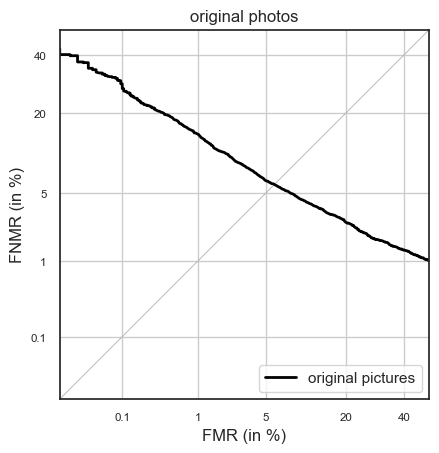

In [17]:
det = DET(biometric_evaluation_type='algorithm', abbreviate_axes=True, plot_eer_line=True, plot_title="original photos")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.legend_on()
det.show()




Now we are able to see the whole spectrum of the trade-off between false positive occurrences (false match rate - FMR) and false negative occurrences (false non-match rate - FNMR). Also drawn (faint grey) is the so-called equal-error-rate (EER) line -- which merely goes through points where the FMR and FNMR are equal. It is sometimes used to summarise the biometric performance of a system in a single number, but it may be misleading (not showing the whole picture) in some cases. We can see the EER is where the grey and black lines intersect -- around 5%. Last, but not least, how do we benchmark (compare) the biometric performance of two or more systems? It is simple -- we plot their respective DET curves in one figure.

### Load mated scores for gaussian blur

In [18]:
mated_scores_gaussian1file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_blur1.txt"
mated_scores_gaussian1 = np.loadtxt(mated_scores_gaussian1file)

mated_scores_gaussian2file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_blur2.txt"
mated_scores_gaussian2 = np.loadtxt(mated_scores_gaussian2file)

mated_scores_gaussian3file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_blur3.txt"
mated_scores_gaussian3 = np.loadtxt(mated_scores_gaussian3file)

mated_score_gaussian4file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_blur4.txt"
mated_scores_gaussian4 = np.loadtxt(mated_score_gaussian4file)

mated_score_gaussian5file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_blur5.txt"
mated_scores_gaussian5 = np.loadtxt(mated_score_gaussian5file)

mated_score_gaussian6file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_blur6.txt"
mated_scores_gaussian6 = np.loadtxt(mated_score_gaussian6file)

mated_score_gaussian7file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_blur7.txt"
mated_scores_gaussian7 = np.loadtxt(mated_score_gaussian7file)

mated_score_gaussian8file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_blur8.txt"
mated_scores_gaussian8 = np.loadtxt(mated_score_gaussian8file)

mated_score_gaussian9file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_blur9.txt"
mated_scores_gaussian9 = np.loadtxt(mated_score_gaussian9file)


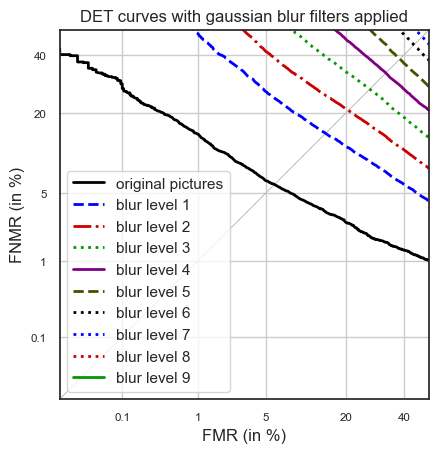

In [19]:
det = DET(biometric_evaluation_type='algorithm', abbreviate_axes=True, plot_eer_line=True, plot_title="DET curves with gaussian blur filters applied")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.plot(tar=adjust_scores_for_DET(mated_scores_gaussian1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 1")
det.plot(tar=adjust_scores_for_DET(mated_scores_gaussian2, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 2")
det.plot(tar=adjust_scores_for_DET(mated_scores_gaussian3, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 3")
det.plot(tar=adjust_scores_for_DET(mated_scores_gaussian4, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 4")
det.plot(tar=adjust_scores_for_DET(mated_scores_gaussian5, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 5")
det.plot(tar=adjust_scores_for_DET(mated_scores_gaussian6, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 6")
det.plot(tar=adjust_scores_for_DET(mated_scores_gaussian7, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 7")
det.plot(tar=adjust_scores_for_DET(mated_scores_gaussian8, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 8")
det.plot(tar=adjust_scores_for_DET(mated_scores_gaussian9, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 9")

det.legend_on(loc="lower left")
det.show()

### Load mated scores for median blur

In [20]:
mated_scores_median1file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_medianblur1.txt"
mated_scores_median1 = np.loadtxt(mated_scores_median1file)

mated_scores_median2file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_medianblur2.txt"
mated_scores_median2 = np.loadtxt(mated_scores_median2file)

mated_scores_median3file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_medianblur3.txt"
mated_scores_median3 = np.loadtxt(mated_scores_median3file)

mated_score_median4file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_medianblur4.txt"
mated_scores_median4 = np.loadtxt(mated_score_median4file)

mated_score_median5file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_medianblur5.txt"
mated_scores_median5 = np.loadtxt(mated_score_median5file)

mated_score_median6file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_medianblur6.txt"
mated_scores_median6 = np.loadtxt(mated_score_median6file)

mated_score_median7file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_medianblur7.txt"
mated_scores_median7 = np.loadtxt(mated_score_median7file)

mated_score_median8file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_medianblur8.txt"
mated_scores_median8 = np.loadtxt(mated_score_median8file)

mated_score_median9file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_medianblur9.txt"
mated_scores_median9 = np.loadtxt(mated_score_median9file)


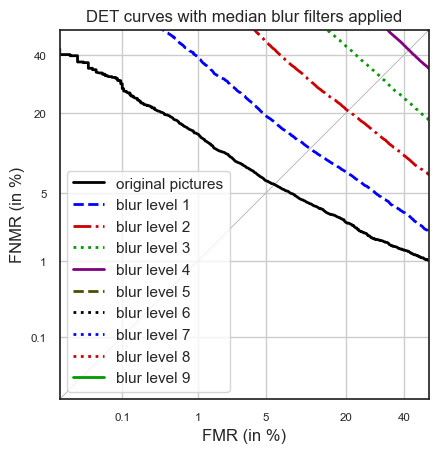

In [21]:
det = DET(biometric_evaluation_type='algorithm', abbreviate_axes=True, plot_eer_line=True, plot_title="DET curves with median blur filters applied")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.plot(tar=adjust_scores_for_DET(mated_scores_median1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 1")
det.plot(tar=adjust_scores_for_DET(mated_scores_median2, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 2")
det.plot(tar=adjust_scores_for_DET(mated_scores_median3, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 3")
det.plot(tar=adjust_scores_for_DET(mated_scores_median4, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 4")
det.plot(tar=adjust_scores_for_DET(mated_scores_median5, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 5")
det.plot(tar=adjust_scores_for_DET(mated_scores_median6, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 6")
det.plot(tar=adjust_scores_for_DET(mated_scores_median7, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 7")
det.plot(tar=adjust_scores_for_DET(mated_scores_median8, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 8")
det.plot(tar=adjust_scores_for_DET(mated_scores_median9, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="blur level 9")

det.legend_on(loc="lower left")
det.show()

### Load mated scores for pixelization

In [22]:
mated_scores_pixelization1file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_pixelization1.txt"
mated_scores_pixelization1 = np.loadtxt(mated_scores_pixelization1file)

mated_scores_pixelization2file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_pixelization2.txt"
mated_scores_pixelization2 = np.loadtxt(mated_scores_pixelization2file)

mated_scores_pixelization3file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_pixelization3.txt"
mated_scores_pixelization3 = np.loadtxt(mated_scores_pixelization3file)

mated_score_pixelization4file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_pixelization4.txt"
mated_scores_pixelization4 = np.loadtxt(mated_score_pixelization4file)

mated_score_pixelization5file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_pixelization5.txt"
mated_scores_pixelization5 = np.loadtxt(mated_score_pixelization5file)

mated_score_pixelization6file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_pixelization6.txt"
mated_scores_pixelization6 = np.loadtxt(mated_score_pixelization6file)

mated_score_pixelization7file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_pixelization7.txt"
mated_scores_pixelization7 = np.loadtxt(mated_score_pixelization7file)

mated_score_pixelization8file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_pixelization8.txt"
mated_scores_pixelization8 = np.loadtxt(mated_score_pixelization8file)

mated_score_pixelization9file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_pixelization9.txt"
mated_scores_pixelization9 = np.loadtxt(mated_score_pixelization9file)


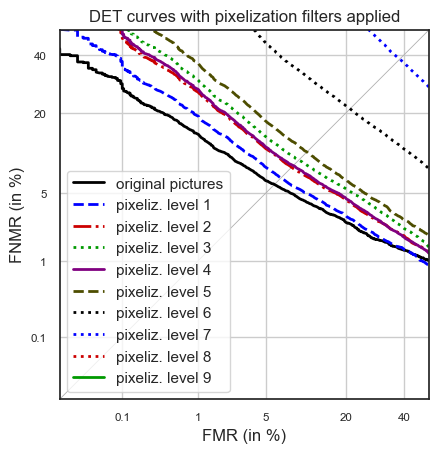

In [23]:
det = DET(biometric_evaluation_type='algorithm', abbreviate_axes=True, plot_eer_line=True, plot_title="DET curves with pixelization filters applied")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.plot(tar=adjust_scores_for_DET(mated_scores_pixelization1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="pixeliz. level 1")
det.plot(tar=adjust_scores_for_DET(mated_scores_pixelization2, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="pixeliz. level 2")
det.plot(tar=adjust_scores_for_DET(mated_scores_pixelization3, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="pixeliz. level 3")
det.plot(tar=adjust_scores_for_DET(mated_scores_pixelization4, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="pixeliz. level 4")
det.plot(tar=adjust_scores_for_DET(mated_scores_pixelization5, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="pixeliz. level 5")
det.plot(tar=adjust_scores_for_DET(mated_scores_pixelization6, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="pixeliz. level 6")
det.plot(tar=adjust_scores_for_DET(mated_scores_pixelization7, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="pixeliz. level 7")
det.plot(tar=adjust_scores_for_DET(mated_scores_pixelization8, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="pixeliz. level 8")
det.plot(tar=adjust_scores_for_DET(mated_scores_pixelization9, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="pixeliz. level 9")

det.legend_on(loc="lower left")
det.show()

### Load mated scores for masking opacity

In [24]:
mated_scores_masked1file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked1.txt"
mated_scores_masked1 = np.loadtxt(mated_scores_masked1file)

mated_scores_masked2file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked2.txt"
mated_scores_masked2 = np.loadtxt(mated_scores_masked2file)

mated_scores_masked3file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked3.txt"
mated_scores_masked3 = np.loadtxt(mated_scores_masked3file)

mated_score_masked4file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked4.txt"
mated_scores_masked4 = np.loadtxt(mated_score_masked4file)

mated_score_masked5file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked5.txt"
mated_scores_masked5 = np.loadtxt(mated_score_masked5file)

mated_score_masked6file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked6.txt"
mated_scores_masked6 = np.loadtxt(mated_score_masked6file)

mated_score_masked7file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked7.txt"
mated_scores_masked7 = np.loadtxt(mated_score_masked7file)

mated_score_masked8file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked8.txt"
mated_scores_masked8 = np.loadtxt(mated_score_masked8file)

mated_score_masked9file = "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked9.txt"
mated_scores_masked9 = np.loadtxt(mated_score_masked9file)


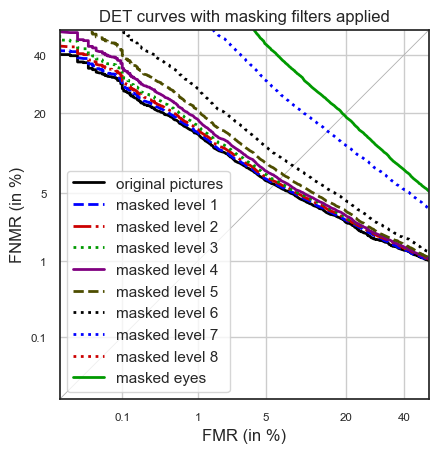

In [25]:
det = DET(biometric_evaluation_type='algorithm', abbreviate_axes=True, plot_eer_line=True, plot_title="DET curves with masking filters applied")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.plot(tar=adjust_scores_for_DET(mated_scores_masked1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="masked level 1")
det.plot(tar=adjust_scores_for_DET(mated_scores_masked2, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="masked level 2")
det.plot(tar=adjust_scores_for_DET(mated_scores_masked3, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="masked level 3")
det.plot(tar=adjust_scores_for_DET(mated_scores_masked4, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="masked level 4")
det.plot(tar=adjust_scores_for_DET(mated_scores_masked5, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="masked level 5")
det.plot(tar=adjust_scores_for_DET(mated_scores_masked6, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="masked level 6")
det.plot(tar=adjust_scores_for_DET(mated_scores_masked7, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="masked level 7")
det.plot(tar=adjust_scores_for_DET(mated_scores_masked8, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="masked level 8")
det.plot(tar=adjust_scores_for_DET(mated_scores_masked9, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label="masked eyes")

det.legend_on(loc="lower left")
det.show()

We can thus conclude that across the whole spectrum, system 2 performs significantly better (has lower error rates) than system 1. Another metric commonly used to describe a system's biometric performance (accuracy) is equal-error-rate (EER). It can be computed by interpolating on FMR and FNMR values or read from the figure directly. It simply denotes the point at which the two error rates are equal, i.e. FMR == FNMR. That is the point, where the grey diagonal line starting at origin intersects with the DET curves for the respective systems. For example, the EER for system 1 would be around 5%, whereas for system 2 it would be below 1%.

## precision recall plot

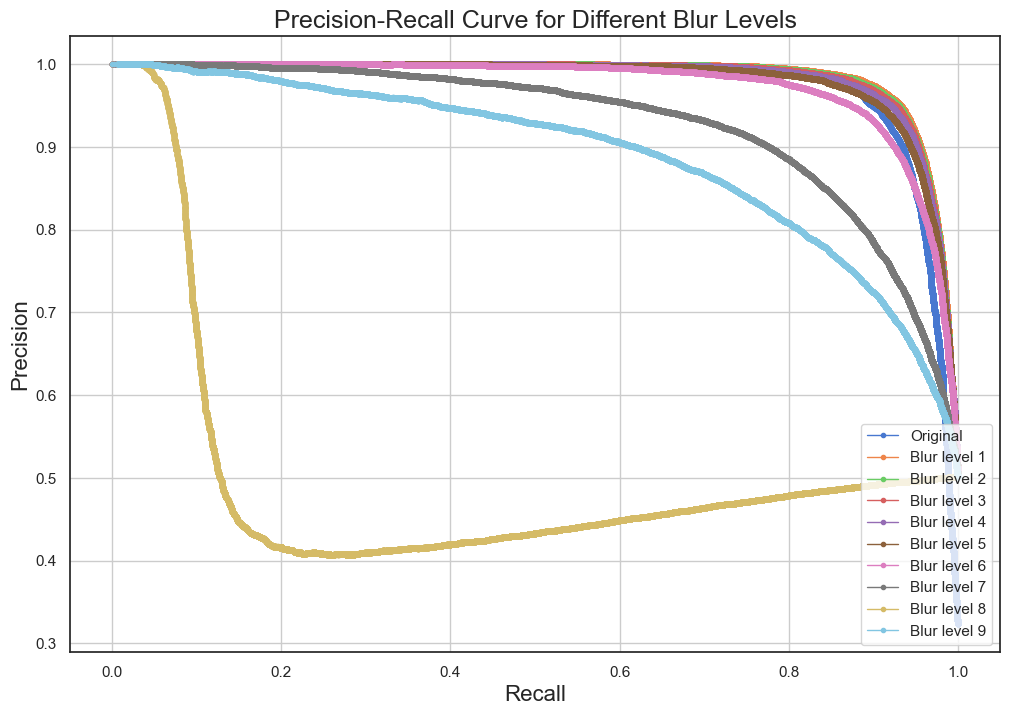

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Funzione per calcolare precisione e richiamo
def calculate_precision_recall(mated_scores, nonmated_scores, scores_type):
    y_true = np.concatenate([np.ones(len(mated_scores)), np.zeros(len(nonmated_scores))])
    scores = np.concatenate([mated_scores, nonmated_scores])

    if scores_type == "similarity":
        precision, recall, thresholds = precision_recall_curve(y_true, scores)
    elif scores_type == "dissimilarity":
        precision, recall, thresholds = precision_recall_curve(y_true, -scores)
    else:
        raise ValueError(f"Unknown type of comparison scores: {scores_type}")

    return precision, recall, thresholds

# File paths
mated_files = [
    "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_original.txt",
    "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked1.txt",
    "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked2.txt",
    "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked3.txt",
    "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked4.txt",
    "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked5.txt",
    "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked6.txt",
    "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked7.txt",
    "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked8.txt",
    "C:/Users/Admin/Documents/HCAI/BIOMETRIC_SYSTEMS/Face_anonymization_experiments/MagFace/inference/output/mated_correlations_masked9.txt"
]


# Tipo di punteggi (adatta in base ai tuoi dati)
scores_type1 = "similarity"

# Plot della Precision-Recall Curve per ogni livello di blur
plt.figure(figsize=(12, 8))
for i, mated_file in enumerate(mated_files, 1):
    mated_scores = np.loadtxt(mated_file)
    precision, recall, thresholds = calculate_precision_recall(mated_scores, nonmated_scores1, scores_type1)
    label = 'Original' if i == 1 else f'Blur level {i-1}'
    plt.plot(recall, precision, marker='.', linewidth=1, label=label)  # Impostare linewidth=2 per un cambiamento più evidente

plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision-Recall Curve for Different Blur Levels', fontsize=18)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
